In [1]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../web-app/

/Users/dorislee/Desktop/Fall2016/Research/seg/crowd-seg/web-app


In [3]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [4]:
import ast
import matplotlib.image as mpimg
save_db_as_csv()
img_info,object_tbl,bb_info = load_info()

In [41]:
all_x_locs
all_y_locs

{4: [[412, 383, 397, 461, 508, 573, 531, 517, 412]],
 7: [[285, 126, 148, 302, 365, 365, 346, 285]],
 9: [[421, 342, 539, 421],
  [462, 423, 561, 554, 462],
  [574, 426, 406, 442, 448, 438, 452, 548, 574, 574]],
 10: [[420, 393, 385, 431, 420], [407, 374, 443, 450, 407]],
 11: [[370, 343, 455, 370],
  [385, 353, 354, 413, 411, 385],
  [368, 386, 413, 423, 417, 370, 358, 352, 355, 368]]}

For the work quality evaluation methods, given a list of x_locs and y_locs of all of the worker's bounding boxes and sizes of the image, for the same object, return what should be "best region" and confidence score 

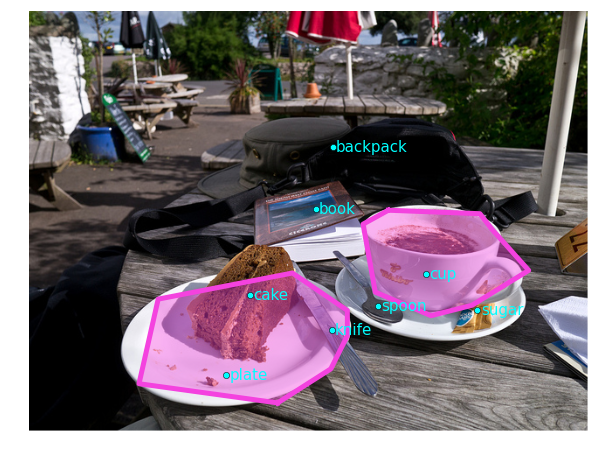

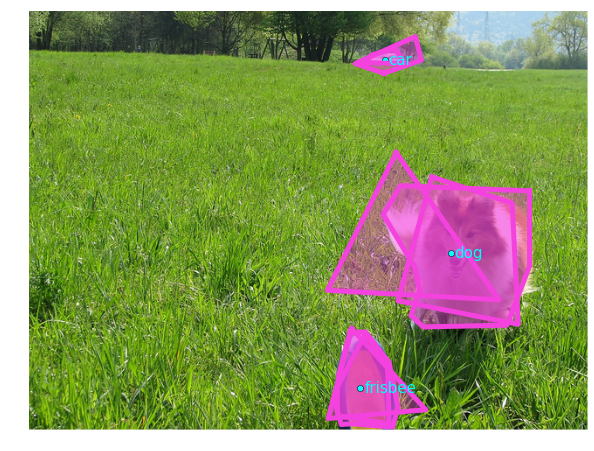

In [40]:
all_x_locs = {}
all_y_locs = {}
for i in np.arange(len(img_info)-5):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        plt.figure(figsize =(10,10))
        plt.imshow(img)
        plt.axis("off")
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]
        plt.plot(filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"],'o',color="cyan")
        for name, x,y in zip(filtered_object_tbl["name"],filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"]):
            plt.text(x+5,y+5,name, fontsize=15,color='cyan')
        #Draw Collected Bounding Boxes
        for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                objid = int(object_tbl[object_tbl.object_id==oid].object_id)
                x_locs = ast.literal_eval(bbx_path)
                y_locs = ast.literal_eval(bby_path)
                # Append the starting point again in the end to close the BB
                x_locs.append(x_locs[0])
                y_locs.append(y_locs[0])
                if objid in all_x_locs.keys():
                    all_x_locs[objid].append(x_locs)
                    all_y_locs[objid].append(y_locs)                    
                else:
                    all_x_locs[objid]=[x_locs]
                    all_y_locs[objid]=[y_locs]
                plt.plot(x_locs,y_locs,'-',color="#f442df",linewidth=5)
                plt.fill_between(x_locs,y_locs,  color="none",facecolor='#f442df', alpha=0.4)
        plt.xlim(0,width)
        plt.ylim(height,0)

In [98]:
from scipy import interpolate

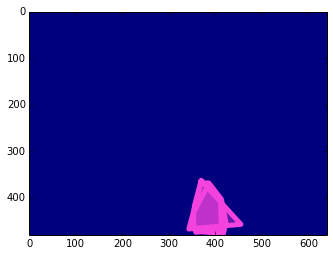

In [47]:
mask = np.zeros((height,width))
objid = 11
obj_x_locs = all_x_locs[objid]
obj_y_locs = all_y_locs[objid]
for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
    plt.plot(x_locs,y_locs,'-',color="#f442df",linewidth=5)
    plt.fill_between(x_locs,y_locs,  color="none",facecolor='#f442df', alpha=0.4)
plt.imshow(mask)

<matplotlib.colorbar.Colorbar instance at 0x11d3244d0>

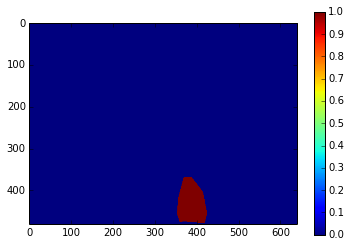

In [115]:
from PIL import Image, ImageDraw
img = Image.new('L', (width, height), 0)
ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
mask = numpy.array(img)==1
plt.imshow(mask)
plt.colorbar()

In [139]:
def majority_vote(all_x_locs,all_y_locs,objid,width,height): 
    '''
    Jaccard Simmilarity or Overlap Method
    used for PASCAL VOC challenge
    '''
    mega_mask = np.zeros((height,width))
    obj_x_locs = all_x_locs[objid]
    obj_y_locs = all_y_locs[objid]
    img = Image.new('L', (width, height), 0)
    for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
        ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
        mask = numpy.array(img)==1
    #     plt.imshow(mask)
        mega_mask+=mask
    #     plt.plot(x_locs,y_locs,'-',color="#f442df",linewidth=5)
    #     plt.fill_between(x_locs,y_locs,  color="none",facecolor='#f442df', alpha=0.4)
    # Show Majority Vote area
    plt.imshow(mega_mask)
    plt.colorbar()
    # Compute Jaccard Simmilarity 
    intersection = len(np.where(mega_mask == mega_mask.max())[0])
    union  =len(np.where(mega_mask !=0)[0])
    return float(union)/intersection

1.2054605149472957

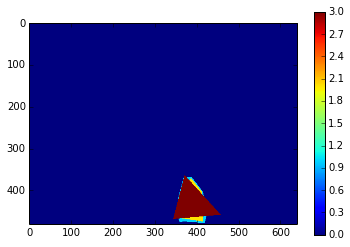

In [140]:
majority_vote(all_x_locs,all_y_locs,11,width,height)

1.8671165644171779

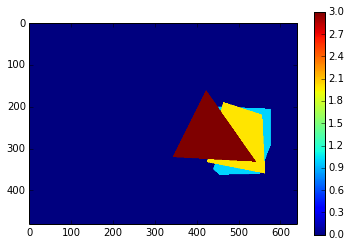

In [141]:
majority_vote(all_x_locs,all_y_locs,9,width,height)